In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
print(tf.__version__)

2022-02-07 10:24:46.973085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-07 10:24:46.973156: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0


## Folders Setup

In [2]:
path = os.getcwd()
data = os.path.join(path,'data')

def folder_setup():
    """ works for linux only

    """
    df = pd.read_csv("train.csv")
    classes = df["label"].drop_duplicates().values.tolist()
    os.mkdir(os.path.join(path,'data'))
    
    # create classes folder
    for classe in classes :
        os.mkdir(os.path.join(path,'data',classe))

    # copy the image in the right classes folder
    for index, values in df.iterrows():
        os.system(f"cp {os.path.join(path,values[1])} {os.path.join(path,'data',values[2],values[1].split('/')[1])}")  

In [3]:
#folder_setup()

In [4]:
img_size = (128, 128)
batch_size = 16

train_ds = keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.75,
    seed=3777,
    subset="training").prefetch(buffer_size=32)

val_ds = keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,
    seed=3777,
    subset="validation").prefetch(buffer_size=32)

Found 1643 files belonging to 19 classes.
Using 411 files for training.


2022-02-07 10:24:52.641667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tanguy/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-07 10:24:52.641703: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-07 10:24:52.641743: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tanguy-UX410UQK): /proc/driver/nvidia/version does not exist
2022-02-07 10:24:52.643112: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1643 files belonging to 19 classes.
Using 246 files for validation.


## Display for fun

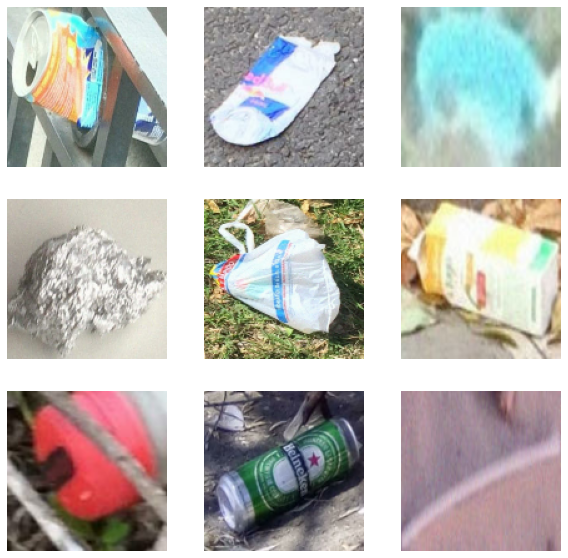

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout

In [7]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(img_size[0],img_size[0],3), activation="relu"),
    Conv2D(32, (3,3), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation="relu"),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding='same', activation="relu"),
    Conv2D(128, (3,3), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(256, (3,3), padding='same', activation="relu"),
    Conv2D(256, (3,3), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(256,activation="relu"),
    Dropout(0.2),
    Dense(19, activation="softmax")
])


model.summary() # To check our model!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor=np.sqrt(0.1),
            patience=3,
            min_lr=0.5e-6)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)

In [10]:
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
history = model.fit(train_ds,
               epochs=10,
               validation_data=val_ds,
               callbacks=[reduce_lr,checkpointer])

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 6.3558 - accuracy: 0.1363
Epoch 1: val_loss improved from inf to 2.81826, saving model to model.hdf5
26/26 [==============================] - 36s 1s/step - loss: 6.3558 - accuracy: 0.1363 - val_loss: 2.8183 - val_accuracy: 0.1138 - lr: 0.0010
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 2.7625 - accuracy: 0.1606
Epoch 2: val_loss improved from 2.81826 to 2.77147, saving model to model.hdf5
26/26 [==============================] - 30s 1s/step - loss: 2.7625 - accuracy: 0.1606 - val_loss: 2.7715 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 2.7305 - accuracy: 0.1509
Epoch 3: val_loss improved from 2.77147 to 2.73775, saving model to model.hdf5
26/26 [==============================] - 34s 1s/step - loss: 2.7305 - accuracy: 0.1509 - val_loss: 2.7378 - val_accuracy: 0.1585 - lr: 0.0010
Epoch 4/10
26/26 [==============================] - ETA: 0s

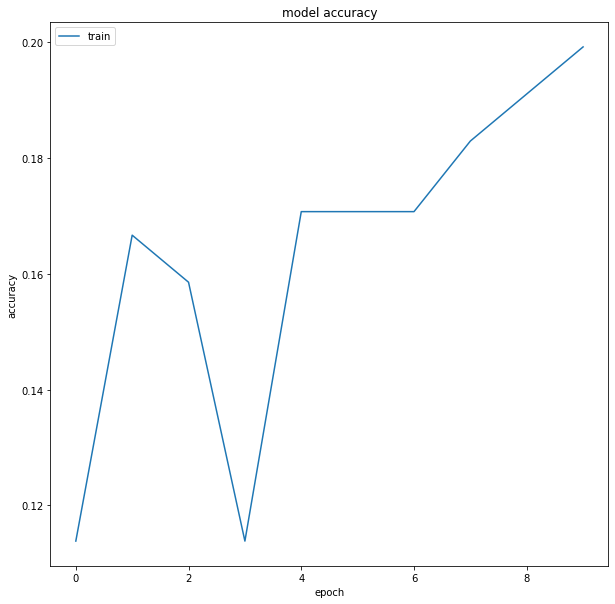

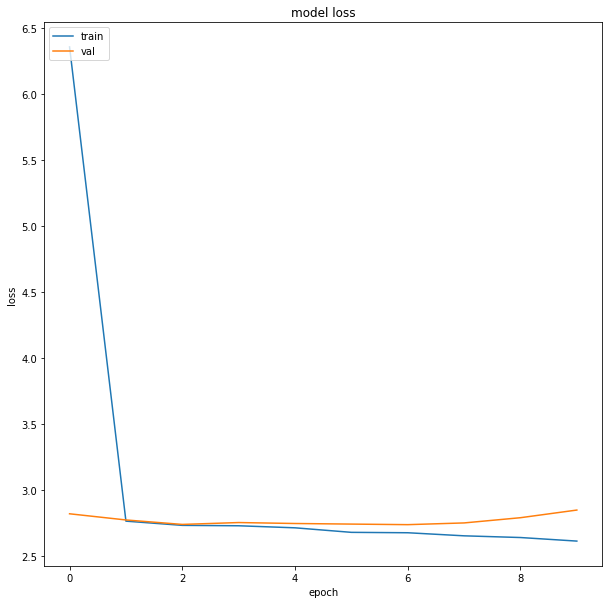

In [12]:
def plot_history(history):
    """
    Plot the loss & accuracy
    """
    plt.figure(figsize=[10,10])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=[10,10])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history)

In [41]:
# prediction
from random import randint
name_img = os.listdir(os.path.join(path,'test'))[randint(0,387)]
random_path_img = os.path.join(path,'test',name_img)
image_array = cv2.imread(random_path_img, cv2.IMREAD_COLOR) # Loading the image
image_array = cv2.resize(image_array, (img_size[0], img_size[0])) # Resize the image
#image = cv2.imread(random_path_img)
#cv2.imshow('image',image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
scores = model.predict(np.array([image_array]))
classes = sorted(os.listdir(data))
print(f'{name_img} -> {classes[scores.argmax(axis=-1)[0]]} {scores.max()}\n\n')
for c,p in zip(classes,scores[0]):
    print(f'{c} prediction : {p}')





210.jpg -> plastic_bottle 0.12465975433588028


aluminium_foil prediction : 0.04117189720273018
carton prediction : 0.07768373936414719
chips_bag prediction : 0.03045460768043995
drink_carton prediction : 0.038829147815704346
glass_bottle prediction : 0.040037866681814194
metal_bottle_cap prediction : 0.042019378393888474
metal_can prediction : 0.10048581659793854
paper prediction : 0.06478534638881683
paper_cup prediction : 0.04545024782419205
paper_tissues prediction : 0.028222769498825073
plastic_bag prediction : 0.05268773064017296
plastic_bottle prediction : 0.12465975433588028
plastic_bottle_cap prediction : 0.06513667851686478
plastic_container prediction : 0.02503226324915886
plastic_cup prediction : 0.046198416501283646
plastic_lid prediction : 0.03965822607278824
plastic_straw prediction : 0.061805516481399536
plastic_tableware prediction : 0.02695714682340622
styrofoam prediction : 0.04872340336441994


In [45]:
def test_predictions():
    with open("test_predictions.csv","w") as file :
        images = []
        test_dir = os.listdir(os.path.join(path,'test'))
        file.write("index,path,pred\n")
        for img in test_dir:
            image_array = cv2.imread(os.path.join(path,'test',img), cv2.IMREAD_COLOR) # Loading the image
            images.append(cv2.resize(image_array, (img_size[0], img_size[0]))) # Resize the image
        scores = model.predict(np.array(images))
        for s,img in zip(scores.argmax(axis=-1),test_dir) :
            classe = classes[s]
            file.write(f"{img.split('.')[0]},train/{img},{classe}\n")

        
test_predictions()